## <img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.2 March 2020  
Copyright &copy; 2003-2022 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='drugitems'></a>drugitems table
The *drugitems* table contains all administered medication including fluids, (parenteral) feeding and blood transfusions during the stay on the ICU. Both bolus injections as well as continous drips are stored in this table. All items have an associated admissionid from the [admissions](admissions.ipynb) table.

## Fields

|Name|Type|Description|
|:--|:---|:---|
|admissionid|integer|links the item with the admissionid in the [admissions](admissions.ipynb) table|
|orderid|integer|uniquely identifies this medication record|
|ordercategoryid|integer|id of medication category, e.g. antibiotics, fluids, etc.|
|[ordercategory](#ordercategory)|string|name of medication category e.g. antibiotics, fluids, etc.|
|itemid|integer|id of the medication name|
|[item](#item)|string|medication name|
|[isadditive](#isadditive)|bit|shows whether this order is an additive, meaning it has been added to a parent solution with the same orderid|
|isconditional|bit|shows whether the order is conditional, meaning the health care provider, should verify if the order should be given at the planned date and time|
|rate|float|rate of medication infusion, expressed as a volume (amount of fluid) per time unit. Rate can be set to 0 for bolus medication (injections)|
|rateunit|string|unit of the infusion rate (e.g. ml/hour)|
|rateunitid|integer|id of the volume unit of the infusion rate|
|ratetimeunitid|integer|id of the time unit of the infusion rate|
|doserateperkg|bit|shows whether the dose rates (if applicable) are dosed by patient weight (e.g. 'mcg/kg/min' instead of 'mcg/min'). In contrast to prescribing medication for pediatric patients, most dose rates for adult intensive care patients are **not** weight based.
|[dose](#dose)|float|prescribed dose, expressed as either an absolute dose (e.g. doseunit = 'mg') or dose per time unit (e.g. doserateunit = 'mg/hour')|
|[doseunit](#doseunit)|string|unit of prescribed dose (e.g. mg)|
|doserateunit|string|time unit of infusion rate (e.g. hour)|
|doseunitid|integer|id of doseunit|
|doserateunitid|integer|id of doserateunit|
|administered|float|administered dose, which may or may not be the same as prescribed dose|
|administeredunit|string|unit of administered dose (e.g. mg)|
|administeredunitid|integer|id of administeredunit|
|[action](#action)|string|defines the reason for documenting (i.e. new bag/syringe, pause, restart, stopped)|
|start|integer|start time of medication infusion in milliseconds from the first admission|
|stop|integer|stop time of medication infusion in milliseconds from the first admission|
|duration|integer|duration of medication infusion (stop - start) in minutes|
|solutionitemid|integer|id of the solution, if any, used to prepare the medication|
|solutionitem|string|name of the solution, if any, used to prepare the medication|
|solutionadministered|float|amount of solution administered|
|solutionadministeredunit|string|unit of solution administered (e.g. ml)|
|fluidin|float|amount of fluid volume administered in ml, including the solution|
|iscontinuous|bit|determines wheter this order is continuous, i.e. restart on empty infusion bag|

# Example Python and SQL scripts

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
sql = """
SELECT * FROM drugitems
LIMIT 10;
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT * FROM drugitems
LIMIT 10;

```

,admissionid,orderid,ordercategoryid,ordercategory,itemid,item,isadditive,isconditional,rate,rateunit,rateunitid,ratetimeunitid,doserateperkg,dose,doseunit,doserateunit,doseunitid,doserateunitid,administered,administeredunit,administeredunitid,action,start,stop,duration,solutionitemid,solutionitem,solutionadministered,solutionadministeredunit,fluidin,iscontinuous
0,0,1994485,15,Injecties Antimicrobiele middelen,9152,Cefazoline (Kefzol),0,0,0.0,None,None,None,0,1.0,g,None,9,NaN,1.0,g,9,Nieuwe toediening,20100000,20160000,1,8987.0,"NaCl 0,9% Medicatie",0.0,ml,0.0,0
1,0,1995066,15,Injecties Antimicrobiele middelen,9152,Cefazoline (Kefzol),0,0,0.0,None,None,None,0,1.0,g,None,9,NaN,1.0,g,9,Nieuwe toediening,52500000,52560000,1,8987.0,"NaCl 0,9% Medicatie",0.0,ml,0.0,0
2,0,1995793,15,Injecties Antimicrobiele middelen,9152,Cefazoline (Kefzol),0,0,0.0,None,None,None,0,1.0,g,None,9,NaN,1.0,g,9,Nieuwe toediening,84900000,84960000,1,8987.0,"NaCl 0,9% Medicatie",0.0,ml,0.0,0
3,0,1994602,17,Infuus - Colloid,7252,Gelofusine,0,0,NaN,None,None,None,0,500.0,ml,uur,6,5.0,500.0,ml,6,Nieuwe zak,30540000,34140000,60,NaN,None,NaN,None,500.0,0
4,0,1994826,17,Infuus - Colloid,7252,Gelofusine,0,0,NaN,None,None,None,0,500.0,ml,uur,6,5.0,500.0,ml,6,Nieuwe zak,45780000,49380000,60,NaN,None,NaN,None,500.0,0
5,0,1995728,17,Infuus - Colloid,7252,Gelofusine,0,0,NaN,None,None,None,0,1000.0,ml,uur,6,5.0,500.0,ml,6,Nieuwe zak,88140000,89940000,30,NaN,None,NaN,None,500.0,0
6,0,1996545,17,Infuus - Colloid,7252,Gelofusine,0,0,NaN,None,None,None,0,500.0,ml,uur,6,5.0,500.0,ml,6,Nieuwe zak,124560000,128160000,60,NaN,None,NaN,None,500.0,0
7,0,1994886,23,Injecties CZS/Sedatie/Analgetica,7225,Morfine,0,0,NaN,None,None,None,0,5.0,mg,None,10,NaN,5.0,mg,10,Nieuwe toediening,47580000,47640000,1,NaN,None,NaN,None,0.0,0
8,0,1995016,23,Injecties CZS/Sedatie/Analgetica,7225,Morfine,0,0,NaN,None,None,None,0,5.0,mg,None,10,NaN,5.0,mg,10,Nieuwe toediening,51660000,51720000,1,NaN,None,NaN,None,0.0,0
9,0,1995143,23,Injecties CZS/Sedatie/Analgetica,7225,Morfine,0,0,NaN,None,None,None,0,2.5,mg,None,10,NaN,2.5,mg,10,Nieuwe toediening,58680000,58740000,1,NaN,None,NaN,None,0.0,0


In [5]:
sql = """
SELECT COUNT(orderid) AS "Total number of medication records", COUNT(DISTINCT orderid) AS "Unique medication records"
FROM drugitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(orderid) AS "Total number of medication records", COUNT(DISTINCT orderid) AS "Unique medication records"
FROM drugitems

```

,Total number of medication records,Unique medication records
0,4907269,4865242


In [6]:
sql = """
SELECT orderid, COUNT(orderid) as NumOrderRecords, COUNT(DISTINCT orderid) AS "Unique medication records"
FROM drugitems
GROUP BY orderid
HAVING COUNT(orderid) >= 2
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT orderid, COUNT(orderid) as NumOrderRecords, COUNT(DISTINCT orderid) AS "Unique medication records"
FROM drugitems
GROUP BY orderid
HAVING COUNT(orderid) >= 2

```

,orderid,numorderrecords,Unique medication records
0,31,3,1
1,271,3,1
2,699,3,1
3,906,3,1
4,1117,3,1
5,1345,3,1
6,1774,2,1
7,2563,2,1
8,4762,3,1
9,4800,3,1


## <a id='isadditive'></a>isadditive
Determines wheter the documented medication order is an additive of a parent solution (such as NaCl 0.9%). Every non-unique orderid, contains one or more additives.

In [7]:
sql = """
SELECT *
FROM drugitems
WHERE orderid IN (
    SELECT orderid
    FROM drugitems
    GROUP BY orderid
    HAVING COUNT(orderid) >= 2
    )
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT *
FROM drugitems
WHERE orderid IN (
    SELECT orderid
    FROM drugitems
    GROUP BY orderid
    HAVING COUNT(orderid) >= 2
    )

```

,admissionid,orderid,ordercategoryid,ordercategory,itemid,item,isadditive,isconditional,rate,rateunit,rateunitid,ratetimeunitid,doserateperkg,dose,doseunit,doserateunit,doseunitid,doserateunitid,administered,administeredunit,administeredunitid,action,start,stop,duration,solutionitemid,solutionitem,solutionadministered,solutionadministeredunit,fluidin,iscontinuous
0,9,3483901,55,Infuus - Crystalloid,7291,"NaCl 0,45%/Glucose 2,5%",0,0,NaN,None,NaN,NaN,0,64.739998,ml,uur,6,5.0,500.000000,ml,6,Nieuwe zak,41760000,69540000,463,NaN,None,NaN,None,500.0,0
1,9,3483901,55,Infuus - Crystalloid,9021,Ascorbinezuur (Vit C),1,0,NaN,None,NaN,NaN,0,0.500000,g,None,9,NaN,0.500000,g,9,Nieuwe toediening,41760000,69540000,463,NaN,None,NaN,None,0.0,0
2,9,3483901,55,Infuus - Crystalloid,9351,Vitamine B Complex,1,0,NaN,None,NaN,NaN,0,0.260000,ml,uur,6,5.0,2.000000,ml,6,Nieuwe toediening,41760000,69540000,463,NaN,None,NaN,None,2.0,0
3,19,5327187,55,Infuus - Crystalloid,7257,Glucose 5 %,0,0,NaN,None,NaN,NaN,0,152.539990,ml,uur,6,5.0,500.000000,ml,6,Nieuwe zak,129360000,141120000,196,NaN,None,NaN,None,500.0,1
4,19,5327187,55,Infuus - Crystalloid,8998,"Natriumbicarbonaat 8,4%",1,0,NaN,None,NaN,NaN,0,27.459999,ml,uur,6,5.0,90.000000,ml,6,Nieuwe toediening,129360000,141120000,196,NaN,None,NaN,None,90.0,1
5,30,1702126,55,Infuus - Crystalloid,7148,Magnesiumsulfaat (MgSO4),1,0,NaN,None,NaN,NaN,0,2.000000,g,None,9,NaN,2.000000,g,9,Nieuwe toediening,7980000,35640000,461,NaN,None,NaN,None,0.0,0
6,30,1702126,55,Infuus - Crystalloid,7291,"NaCl 0,45%/Glucose 2,5%",0,0,NaN,None,NaN,NaN,0,65.000000,ml,uur,6,5.0,500.000000,ml,6,Nieuwe zak,7980000,35640000,461,NaN,None,NaN,None,500.0,0
7,30,1702126,55,Infuus - Crystalloid,7412,Calcium Glubionaat (Calcium Sandoz),1,0,NaN,None,NaN,NaN,0,2.750000,g,None,9,NaN,2.750000,g,9,Nieuwe toediening,7980000,35640000,461,NaN,None,NaN,None,0.0,0
8,135,5711698,55,Infuus - Crystalloid,7257,Glucose 5 %,0,0,NaN,None,NaN,NaN,0,203.390000,ml,uur,6,5.0,197.280000,ml,6,Nieuwe zak,911220000,914700000,58,NaN,None,NaN,None,197.3,1
9,135,5711698,55,Infuus - Crystalloid,8998,"Natriumbicarbonaat 8,4%",1,0,NaN,None,NaN,NaN,0,36.610001,ml,uur,6,5.0,35.509998,ml,6,Nieuwe toediening,911220000,914700000,58,NaN,None,NaN,None,35.5,1


## Orders per admissionid

In [8]:
sql = """
SELECT admissionid
    ,COUNT(orderid) AS "Number of Medication orders"
FROM drugitems
GROUP BY admissionid
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT admissionid
    ,COUNT(orderid) AS "Number of Medication orders"
FROM drugitems
GROUP BY admissionid

```

,admissionid,Number of Medication orders
0,0,62
1,1,46
2,2,57
3,3,27
4,4,81
5,5,131
6,6,93
7,7,48
8,8,34
9,9,113


``` mysql

SELECT admissionid
    ,COUNT(orderid) AS "medication orders per admission"
FROM drugitems
GROUP BY admissionid

```

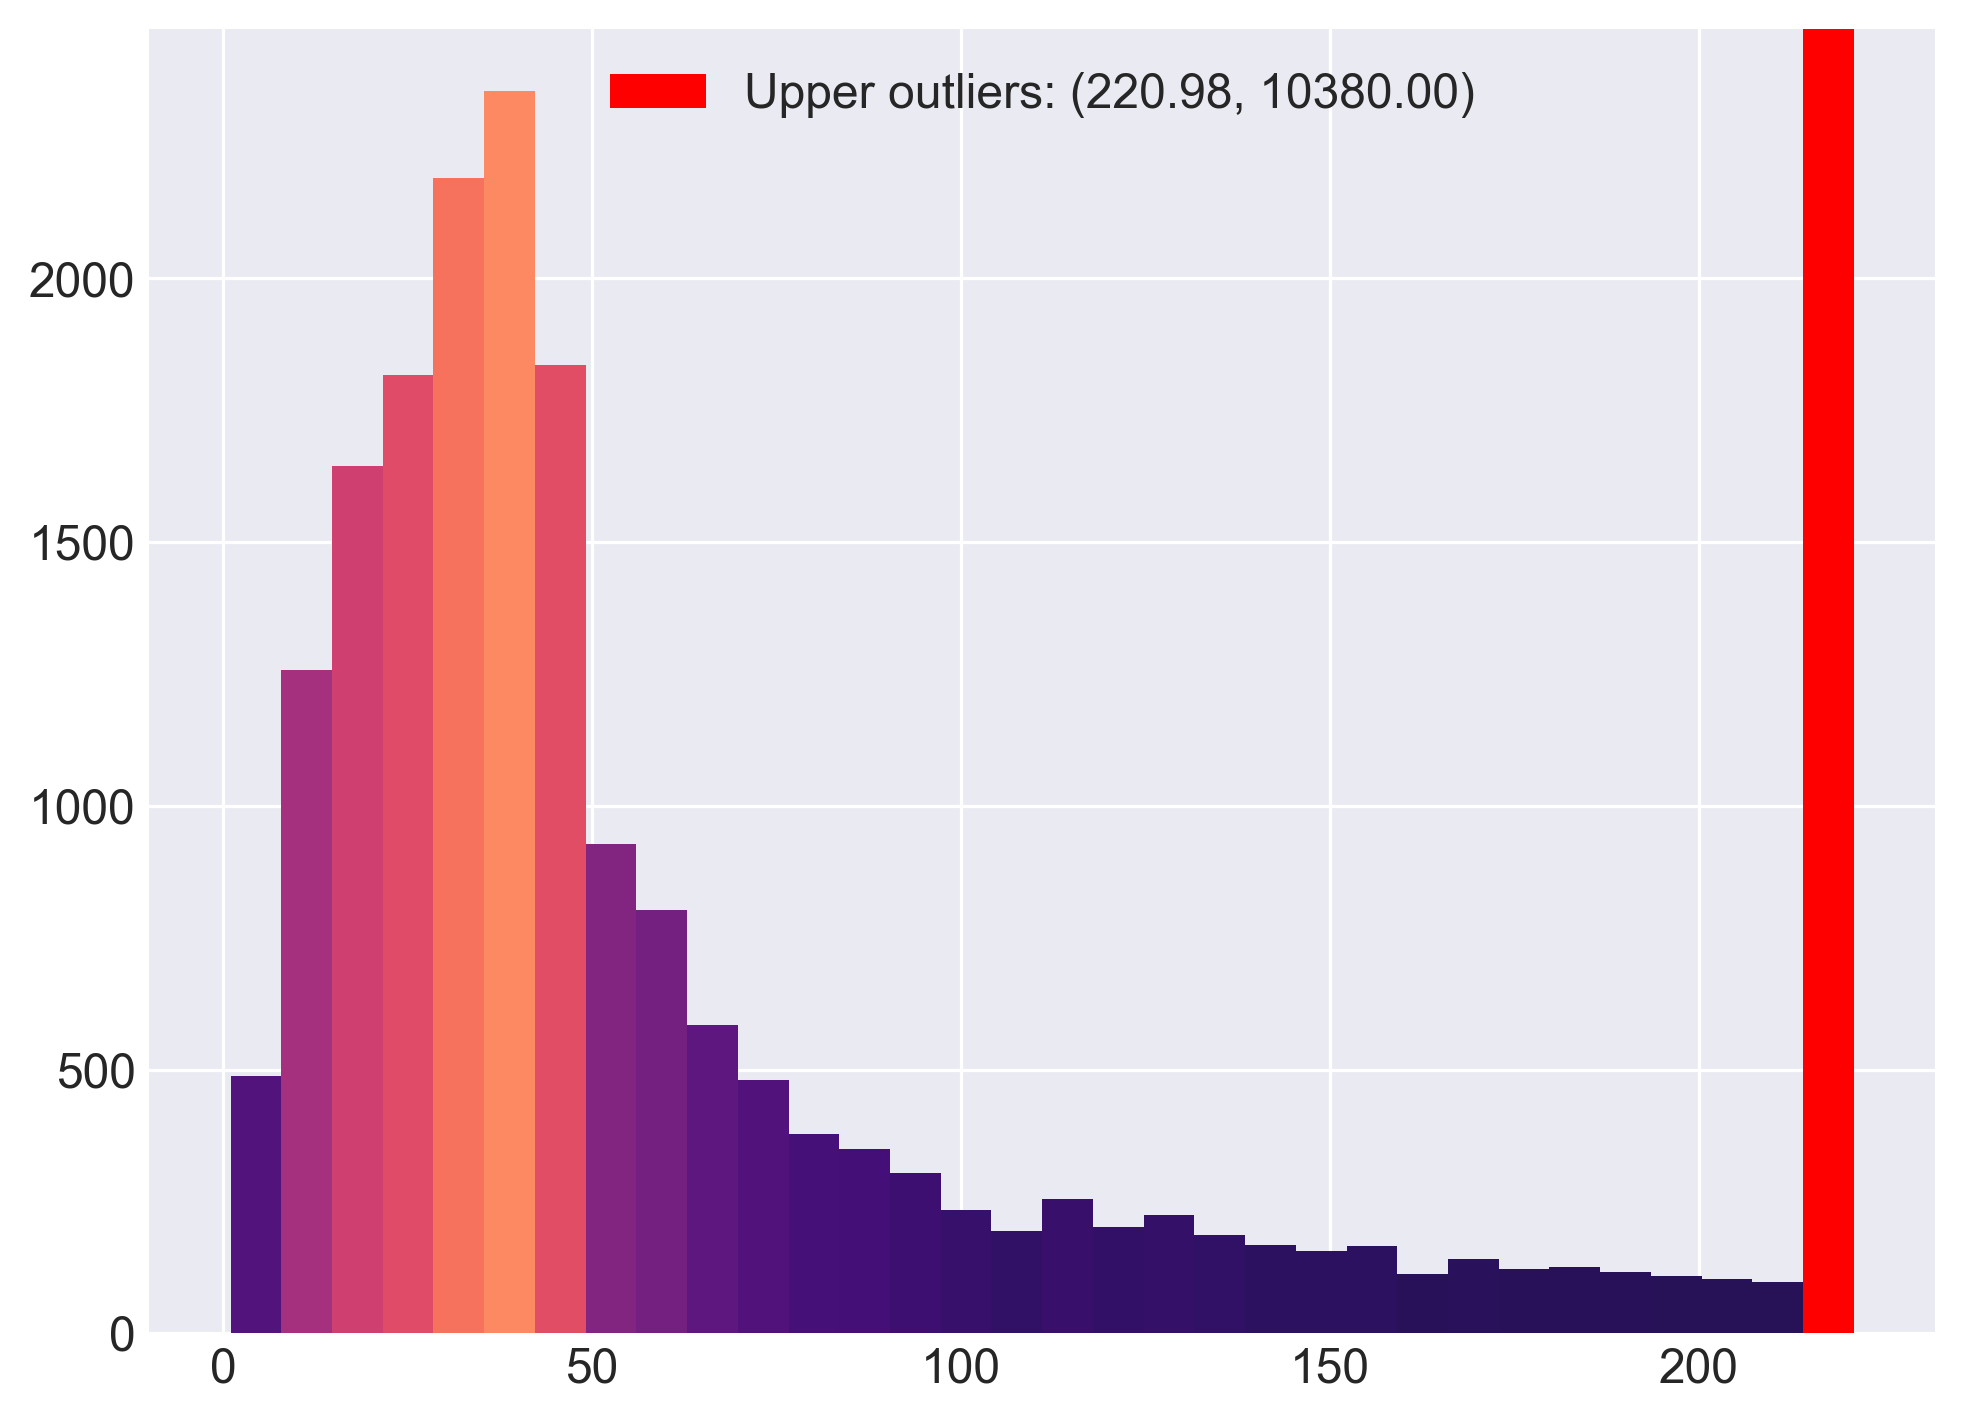

None

In [9]:
sql = """
SELECT admissionid
    ,COUNT(orderid) AS "medication orders per admission"
FROM drugitems
GROUP BY admissionid
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
data = df['medication orders per admission'].fillna(0)
display(amsterdamumcdb.outliers_histogram(data, bins=32).show())

## <a id='ordercategory'></a>ordercategory

In [10]:
sql = """
SELECT DISTINCT ordercategory, ordercategoryid
FROM drugitems
ORDER BY ordercategory
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT DISTINCT ordercategory, ordercategoryid
FROM drugitems
ORDER BY ordercategory

```

,ordercategory,ordercategoryid
0,2. Spuitpompen,65
1,Infuus - Bloedproducten,61
2,Infuus - Colloid,17
3,Infuus - Crystalloid,55
4,Injecties Antimicrobiele middelen,15
5,Injecties Circulatie/Diuretica,24
6,Injecties CZS/Sedatie/Analgetica,23
7,Injecties Haematologisch,25
8,Injecties Hormonen/Vitaminen/Mineralen,67
9,Injecties Overig,27


``` mysql

SELECT ordercategory, COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
GROUP BY ordercategory
ORDER BY "Number of Prescriptions" DESC

```

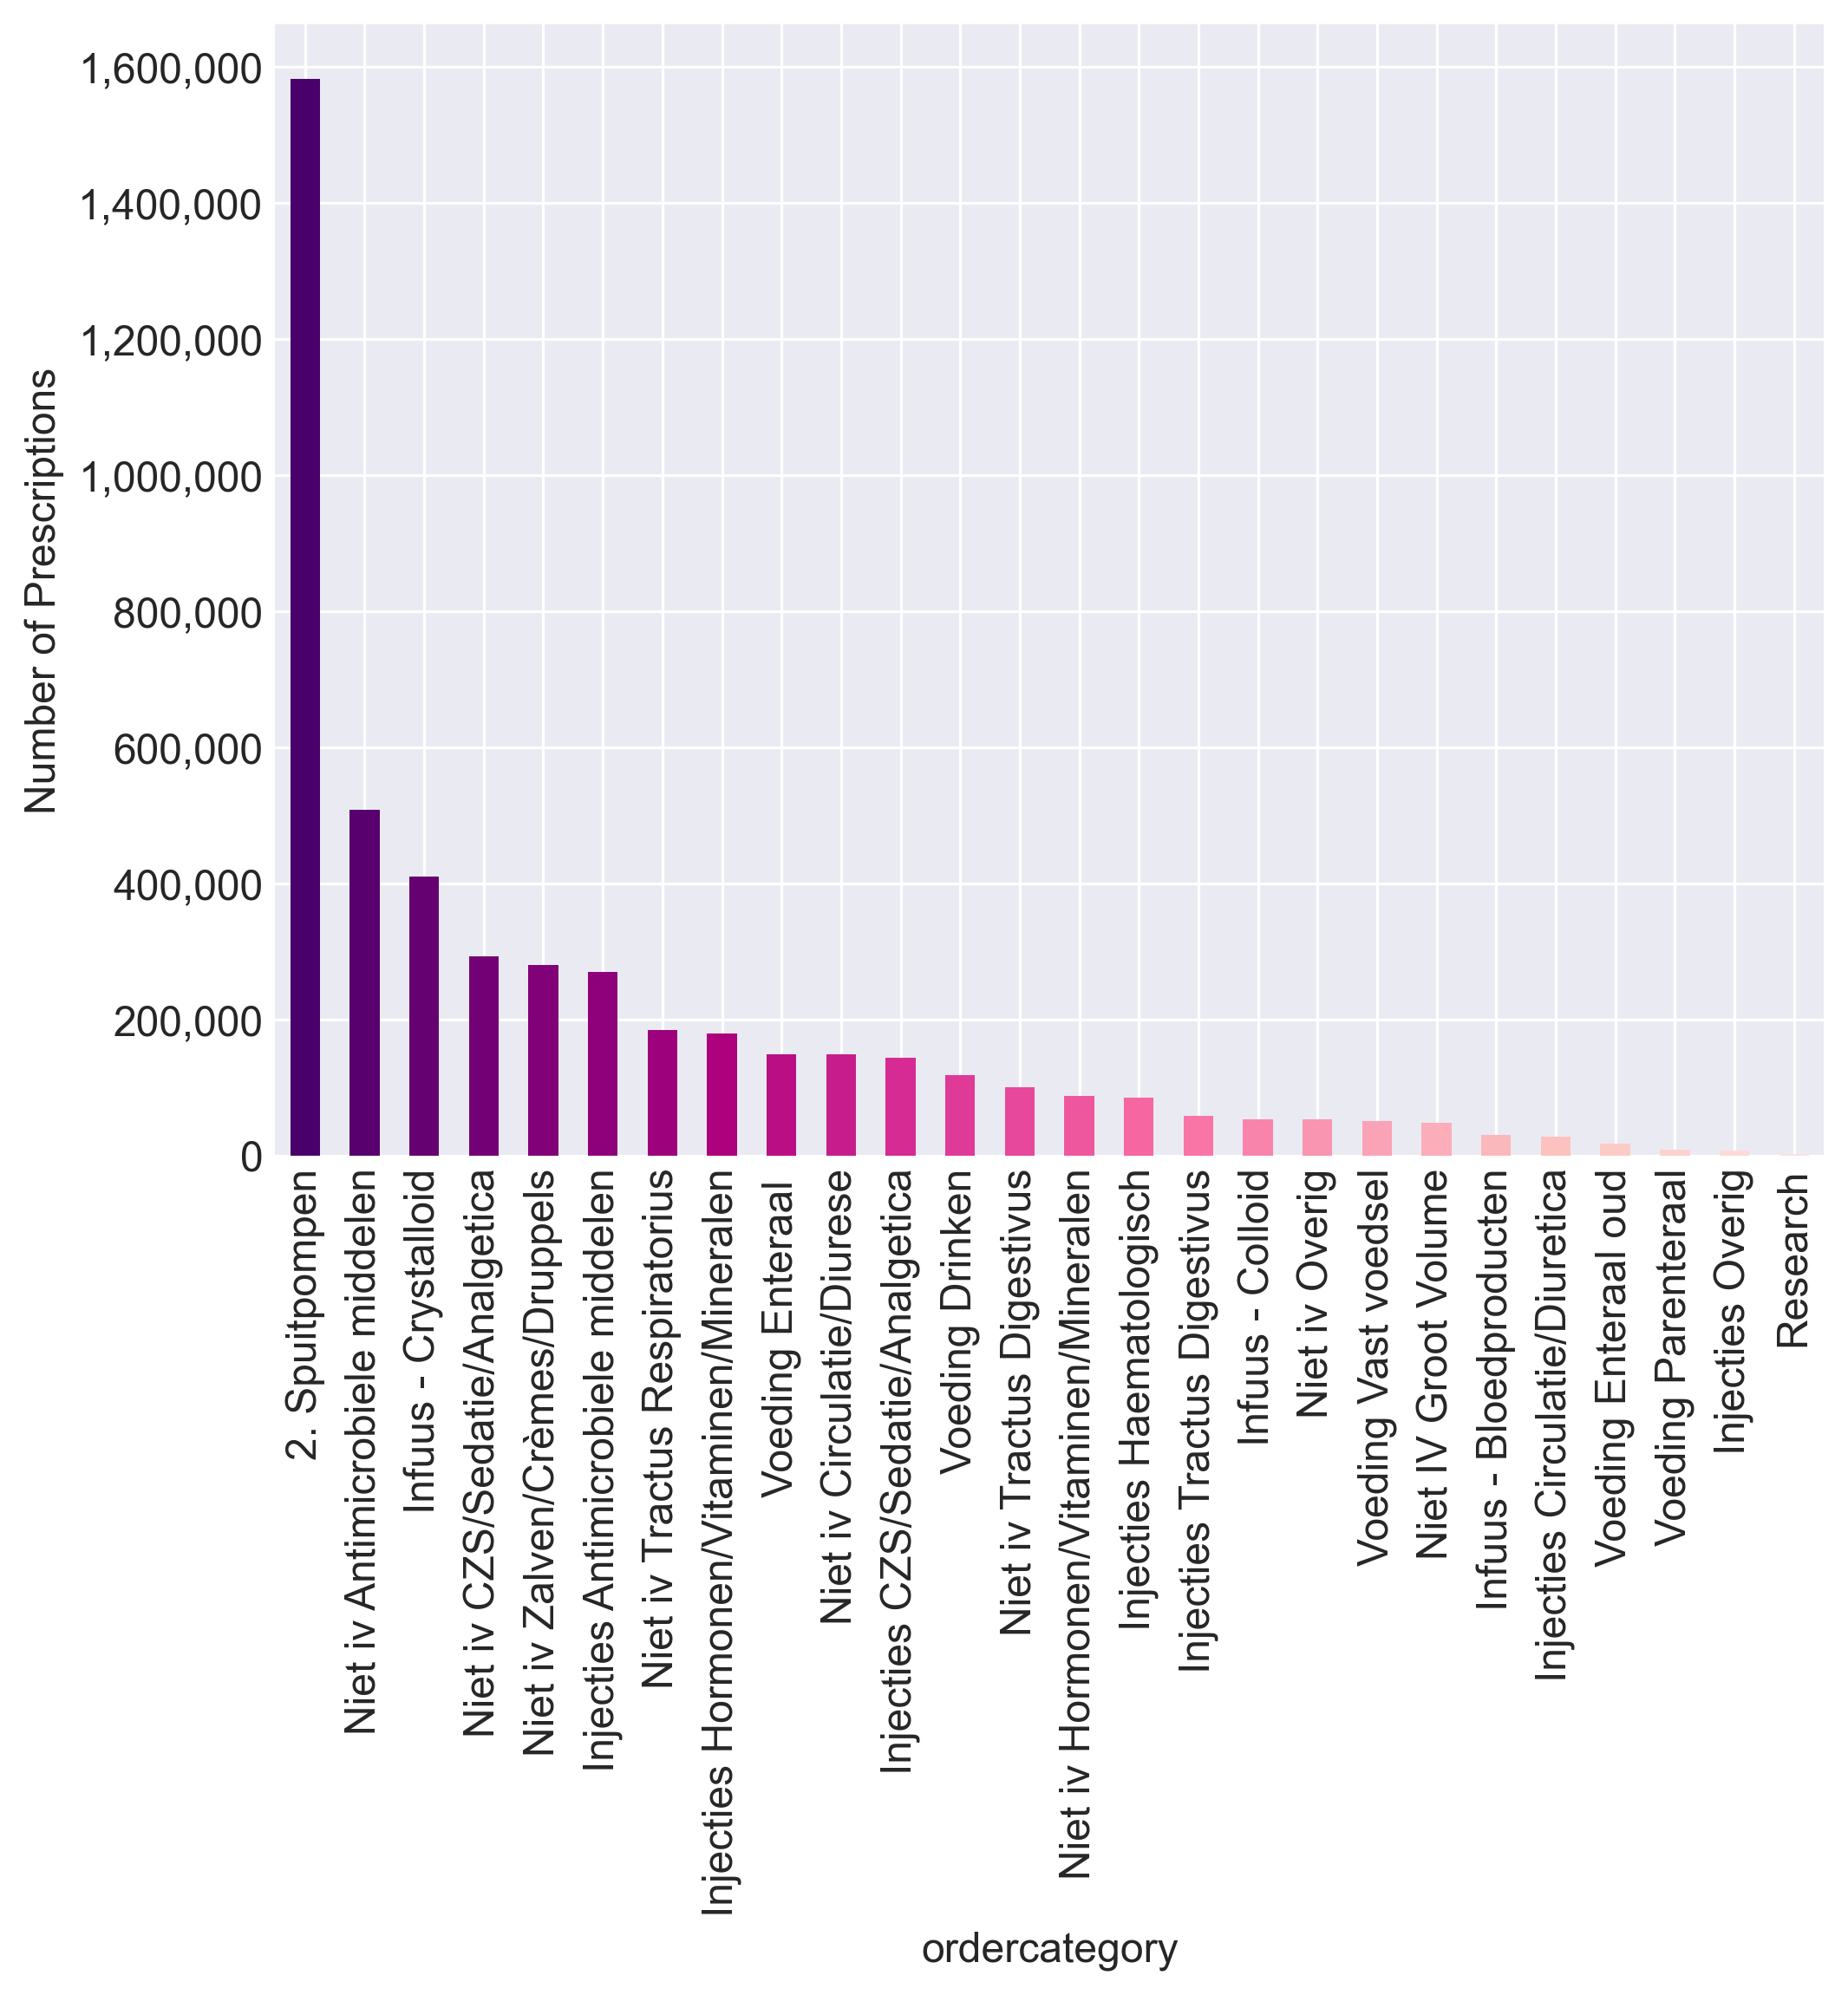

In [11]:
sql = """
SELECT ordercategory, COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
GROUP BY ordercategory
ORDER BY "Number of Prescriptions" DESC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='item'></a> item

``` mysql

SELECT item AS "Drug name", COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
WHERE ordercategoryid = 15 -- antibiotics
GROUP BY item
ORDER BY "Number of Prescriptions" DESC
LIMIT 20 

```

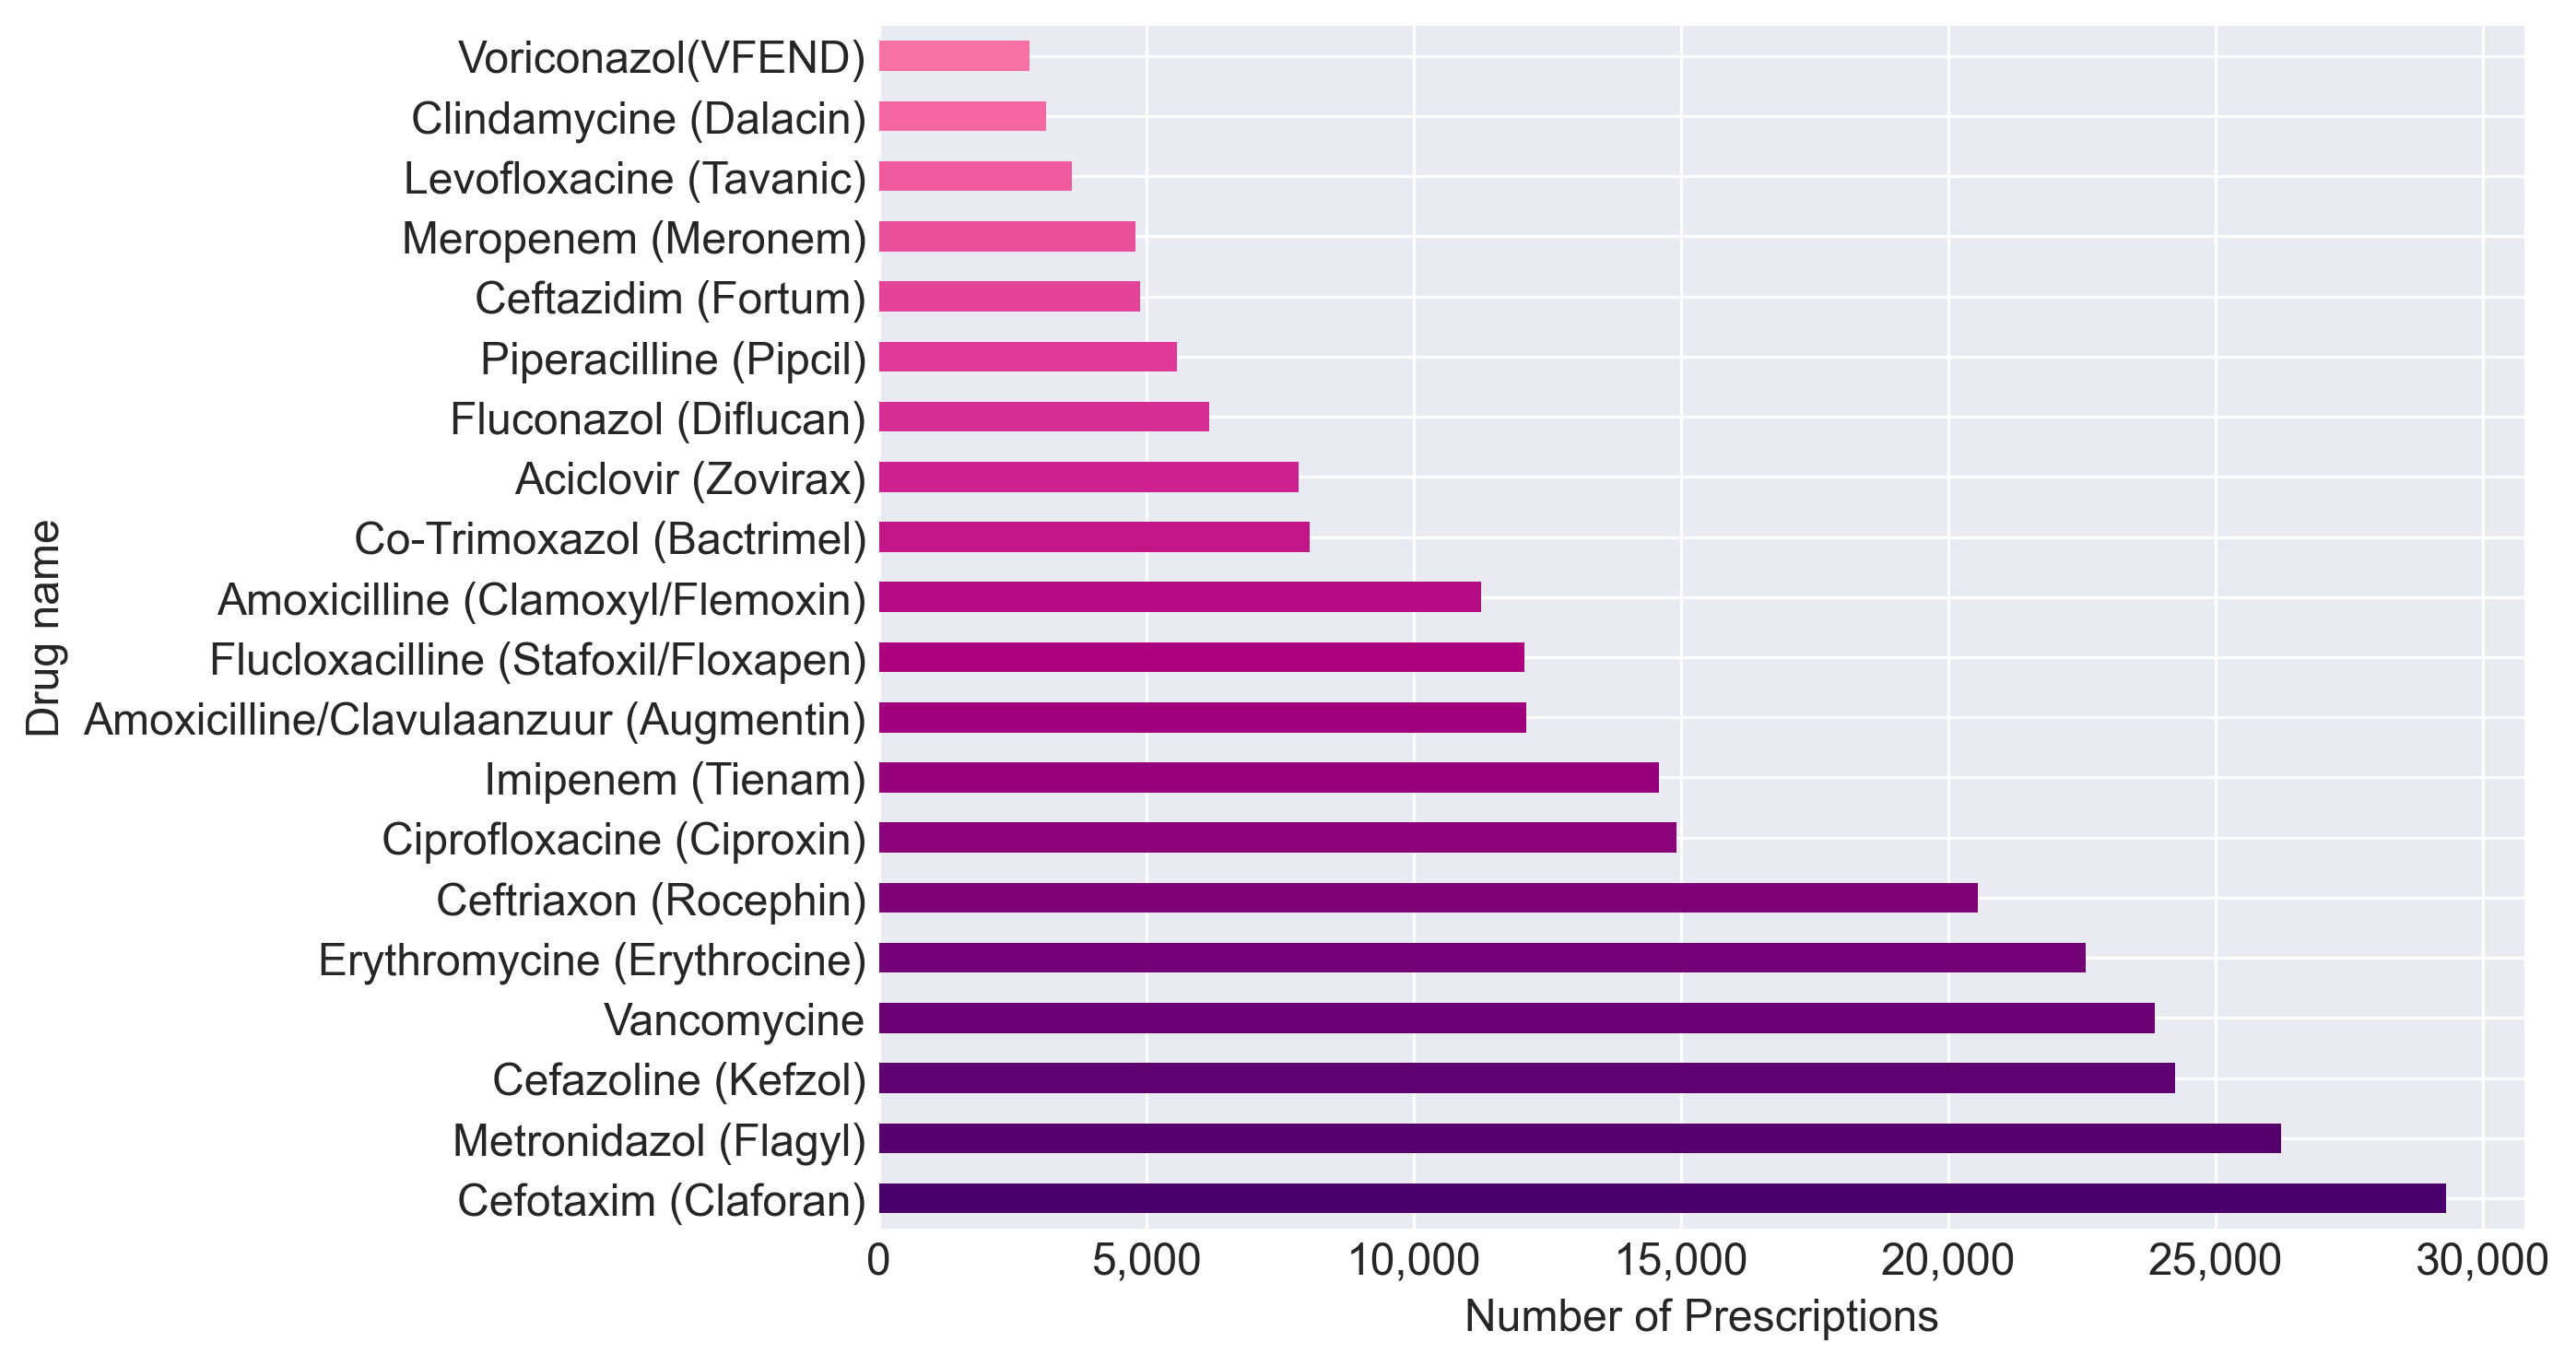

In [12]:
sql = """
SELECT item AS "Drug name", COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
WHERE ordercategoryid = 15 -- antibiotics
GROUP BY item
ORDER BY "Number of Prescriptions" DESC
LIMIT 20 
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-(255-100)/len(df.index))
ax = df.plot.barh(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,100,color_step)))
ax.set(xlabel=df.columns[1])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

``` mysql

SELECT item AS "Drug name", COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
GROUP BY item
ORDER BY "Number of Prescriptions" DESC
LIMIT 20 

```

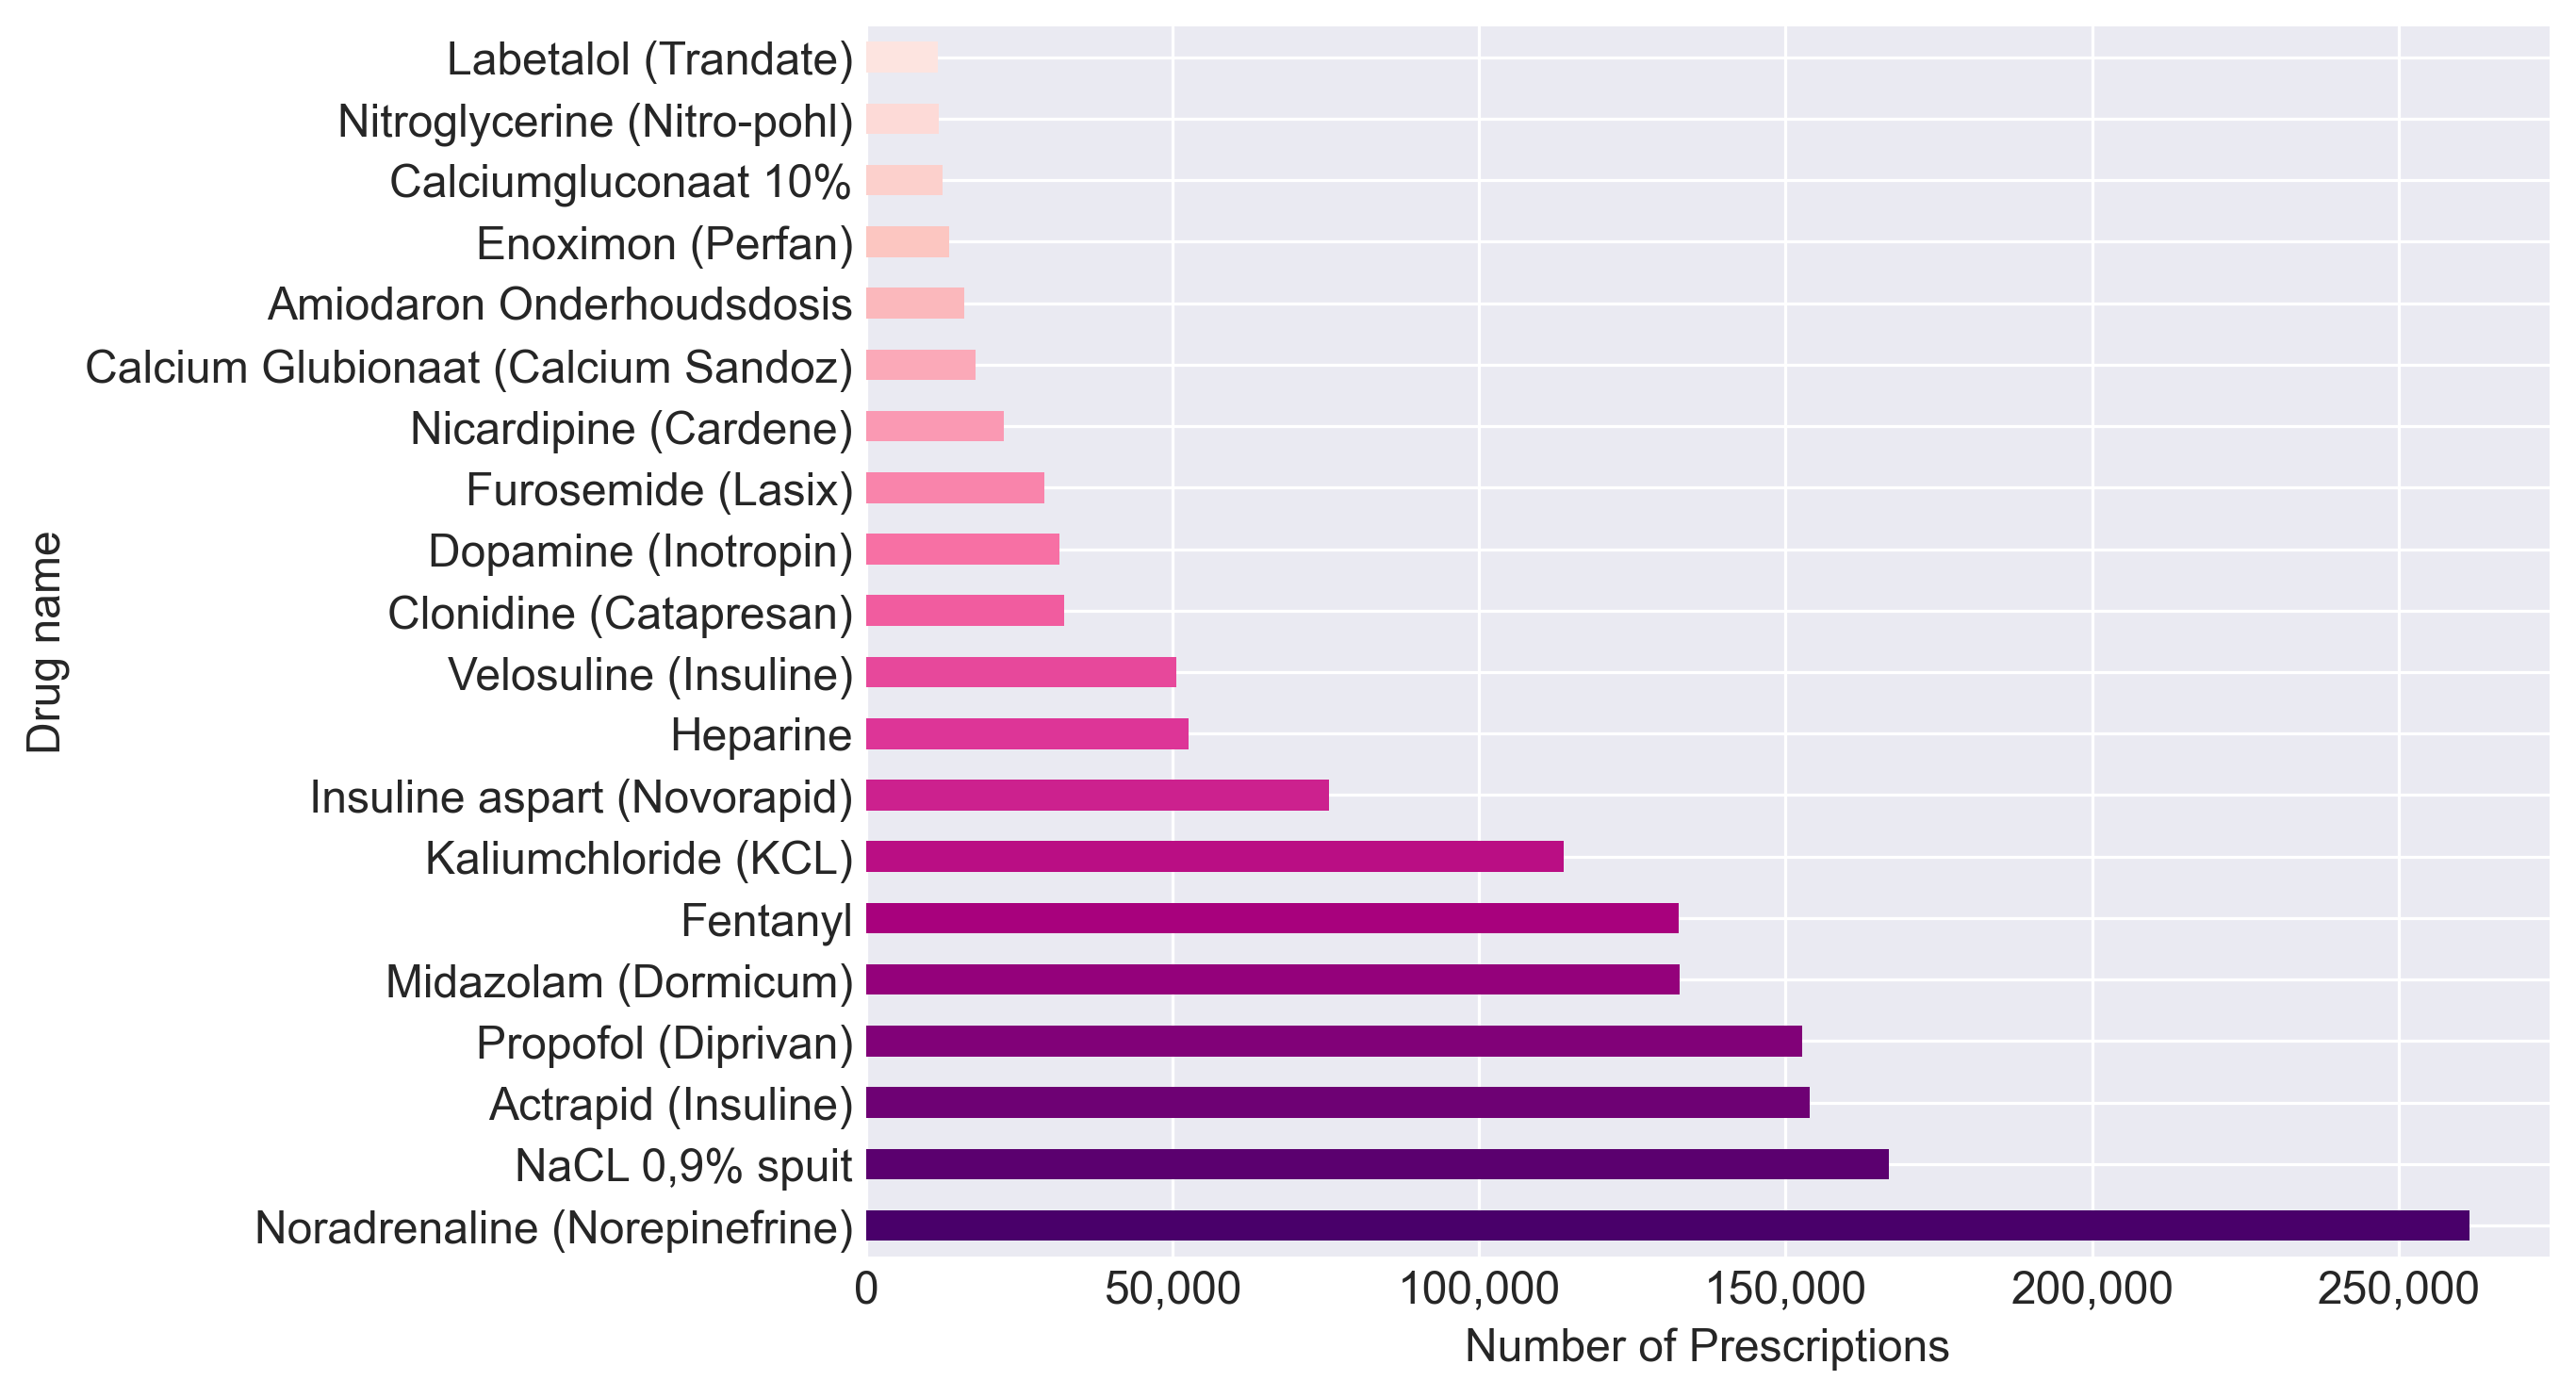

In [13]:
sql = """
SELECT item AS "Drug name", COUNT(orderid) AS "Number of Prescriptions"
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
GROUP BY item
ORDER BY "Number of Prescriptions" DESC
LIMIT 20 
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.barh(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(xlabel=df.columns[1])
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='doseunit'></a>doseunit

In [14]:
sql = """
SELECT DISTINCT rateunit, rateunitid, ratetimeunitid, doserateperkg, doseunit, doserateunit, doseunitid, doserateunitid
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
AND itemid = 7229 -- noradrenalin
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT DISTINCT rateunit, rateunitid, ratetimeunitid, doserateperkg, doseunit, doserateunit, doseunitid, doserateunitid
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
AND itemid = 7229 -- noradrenalin

```

,rateunit,rateunitid,ratetimeunitid,doserateperkg,doseunit,doserateunit,doseunitid,doserateunitid
0,ml/uur,6,5,0,µg,min,11,4
1,ml/uur,6,5,0,mg,min,10,4
2,ml/uur,6,5,0,mg,uur,10,5
3,ml/uur,6,5,1,µg,min,11,4
4,ml/uur,6,5,1,µg,uur,11,5


In [15]:
sql = """
SELECT * 
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
AND itemid = 7229 -- noradrenalin
AND doseunitid = 11
LIMIT 10
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT * 
FROM drugitems
WHERE ordercategoryid = 65 -- continuous i.v. perfusor
AND itemid = 7229 -- noradrenalin
AND doseunitid = 11
LIMIT 10

```

,admissionid,orderid,ordercategoryid,ordercategory,itemid,item,isadditive,isconditional,rate,rateunit,rateunitid,ratetimeunitid,doserateperkg,dose,doseunit,doserateunit,doseunitid,doserateunitid,administered,administeredunit,administeredunitid,action,start,stop,duration,solutionitemid,solutionitem,solutionadministered,solutionadministeredunit,fluidin,iscontinuous
0,2813,3404073,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,3.0,ml/uur,6,5,1,0.17,µg,min,11,4,3.25,mg,10,Nieuwe spuit,6780000,26280000,325,8994,Glucose 5% Pompen,16.299999,ml,16.299999,1
1,2813,3404471,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,2.5,ml/uur,6,5,1,0.14,µg,min,11,4,4.56,mg,10,Snelheid veranderd,26280000,59100000,547,8994,Glucose 5% Pompen,22.799999,ml,22.799999,1
2,2813,3405315,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,4.5,ml/uur,6,5,1,0.25,µg,min,11,4,1.35,mg,10,Snelheid veranderd,59100000,64500000,90,8994,Glucose 5% Pompen,6.700000,ml,6.700000,1
3,2813,3405404,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,5.5,ml/uur,6,5,1,0.31,µg,min,11,4,0.84,mg,10,Snelheid veranderd,64500000,67260000,46,8994,Glucose 5% Pompen,4.200000,ml,4.200000,1
4,2813,3405498,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,5.5,ml/uur,6,5,1,0.24,µg,min,11,4,0.59,mg,10,Nieuwe spuit,67260000,69180000,32,8994,Glucose 5% Pompen,2.900000,ml,2.900000,1
5,2813,3405759,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,6.0,ml/uur,6,5,1,0.27,µg,min,11,4,2.32,mg,10,Snelheid veranderd,69180000,76140000,116,8994,Glucose 5% Pompen,11.600000,ml,11.600000,1
6,2813,3405760,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,8.0,ml/uur,6,5,1,0.36,µg,min,11,4,7.09,mg,10,Snelheid veranderd,76140000,92040000,265,8994,Glucose 5% Pompen,35.400002,ml,35.400002,1
7,2813,3406050,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,8.0,ml/uur,6,5,1,0.36,µg,min,11,4,10.00,mg,10,Nieuwe spuit,92040000,114480000,374,8994,Glucose 5% Pompen,50.000000,ml,50.000000,1
8,2813,3406691,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,8.0,ml/uur,6,5,1,0.36,µg,min,11,4,5.32,mg,10,Nieuwe spuit,114480000,126420000,199,8994,Glucose 5% Pompen,26.600000,ml,26.600000,1
9,2813,3406882,65,2. Spuitpompen,7229,Noradrenaline (Norepinefrine),0,0,15.0,ml/uur,6,5,1,0.67,µg,min,11,4,4.68,mg,10,Snelheid veranderd,126420000,132000000,93,8994,Glucose 5% Pompen,23.400000,ml,23.400000,1


## <a id='dose'></a> dose

``` mysql

WITH dosing AS (
    SELECT start,
        dose,
        drugitems.admissionid,
        doseunitid,
        doserateperkg,
        doserateunitid,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight,
        CASE
            WHEN Destination = 'Overleden' THEN 1
            ELSE 0
        END AS died
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid = 7229 -- noradrenalin
    AND rate > 0
)
SELECT *,
    CASE 
    --recalculate the dose to µg/kg/min ('gamma')
    WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose/patientweight
            ELSE dose/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 4 --unit: mg/min  -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose*1000/patientweight
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose*1000/patientweight/60
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
        THEN dose
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
        THEN dose/60 
    END AS gamma
    FROM dosing
    ORDER BY admissionid, start

```

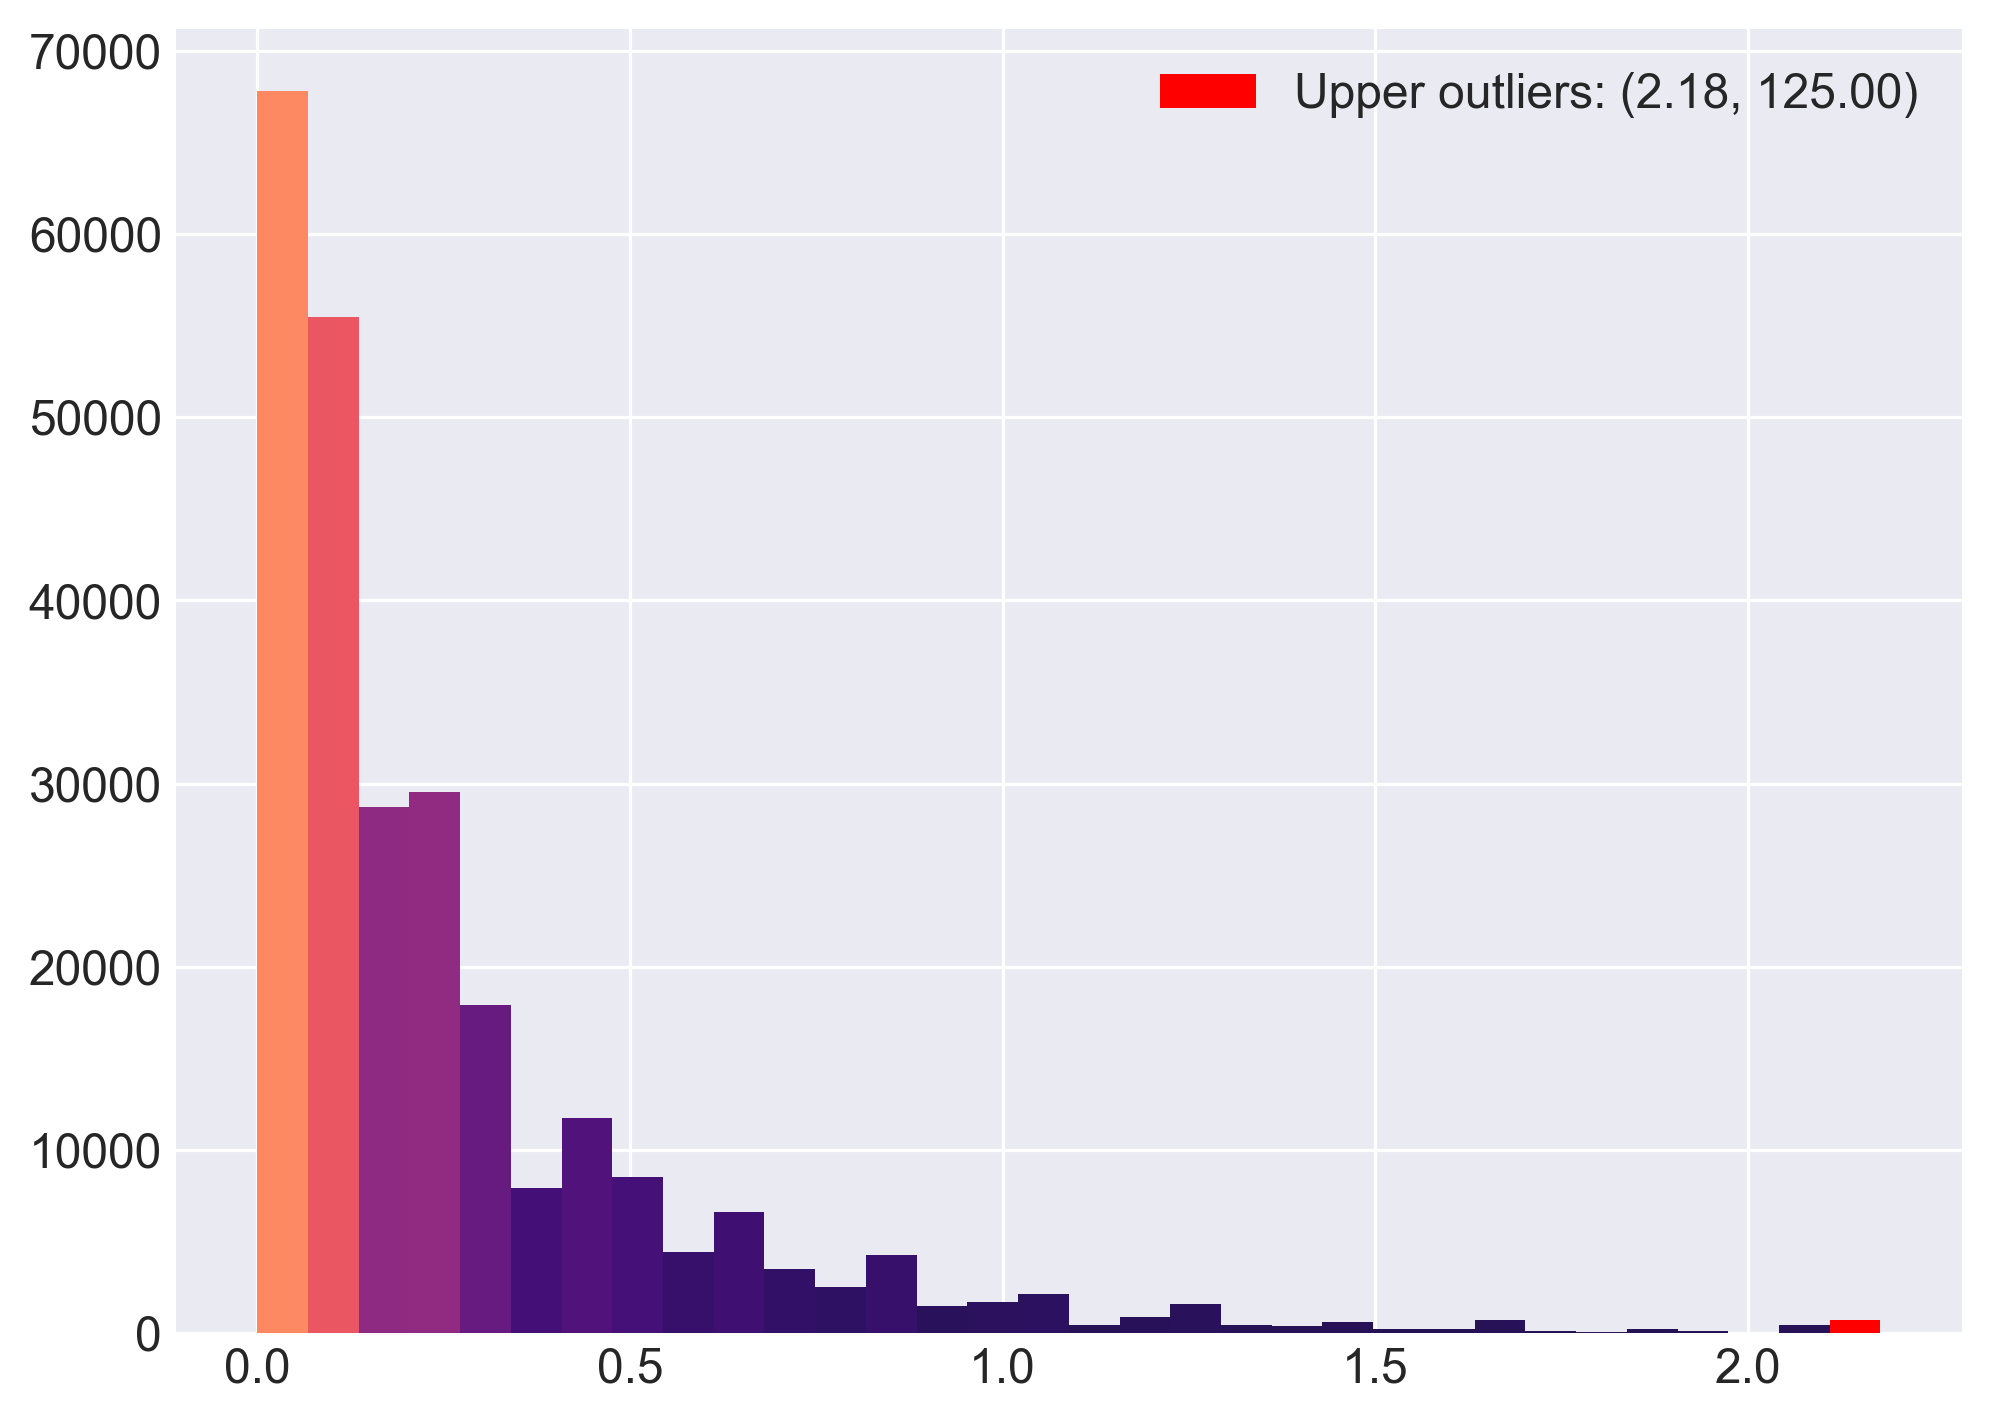

None

In [16]:
sql = """
WITH dosing AS (
    SELECT start,
        dose,
        drugitems.admissionid,
        doseunitid,
        doserateperkg,
        doserateunitid,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight,
        CASE
            WHEN Destination = 'Overleden' THEN 1
            ELSE 0
        END AS died
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid = 7229 -- noradrenalin
    AND rate > 0
)
SELECT *,
    CASE 
    --recalculate the dose to µg/kg/min ('gamma')
    WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose/patientweight
            ELSE dose/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 4 --unit: mg/min  -> µg/kg/min
        THEN CASE 
            WHEN patientweight > 0
            THEN dose*1000/patientweight
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
        THEN CASE
            WHEN patientweight > 0
            THEN dose*1000/patientweight/60
            ELSE dose*1000/80 --mean weight
        END
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
        THEN dose
    WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
        THEN dose/60 
    END AS gamma
    FROM dosing
    ORDER BY admissionid, start
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
data = df['gamma'].fillna(0)
display(amsterdamumcdb.outliers_histogram(data, z_threshold=12, bins=32).show())

Text(0.5, 1.0, 'Highest noradrenaline dose in the first 24 hours')

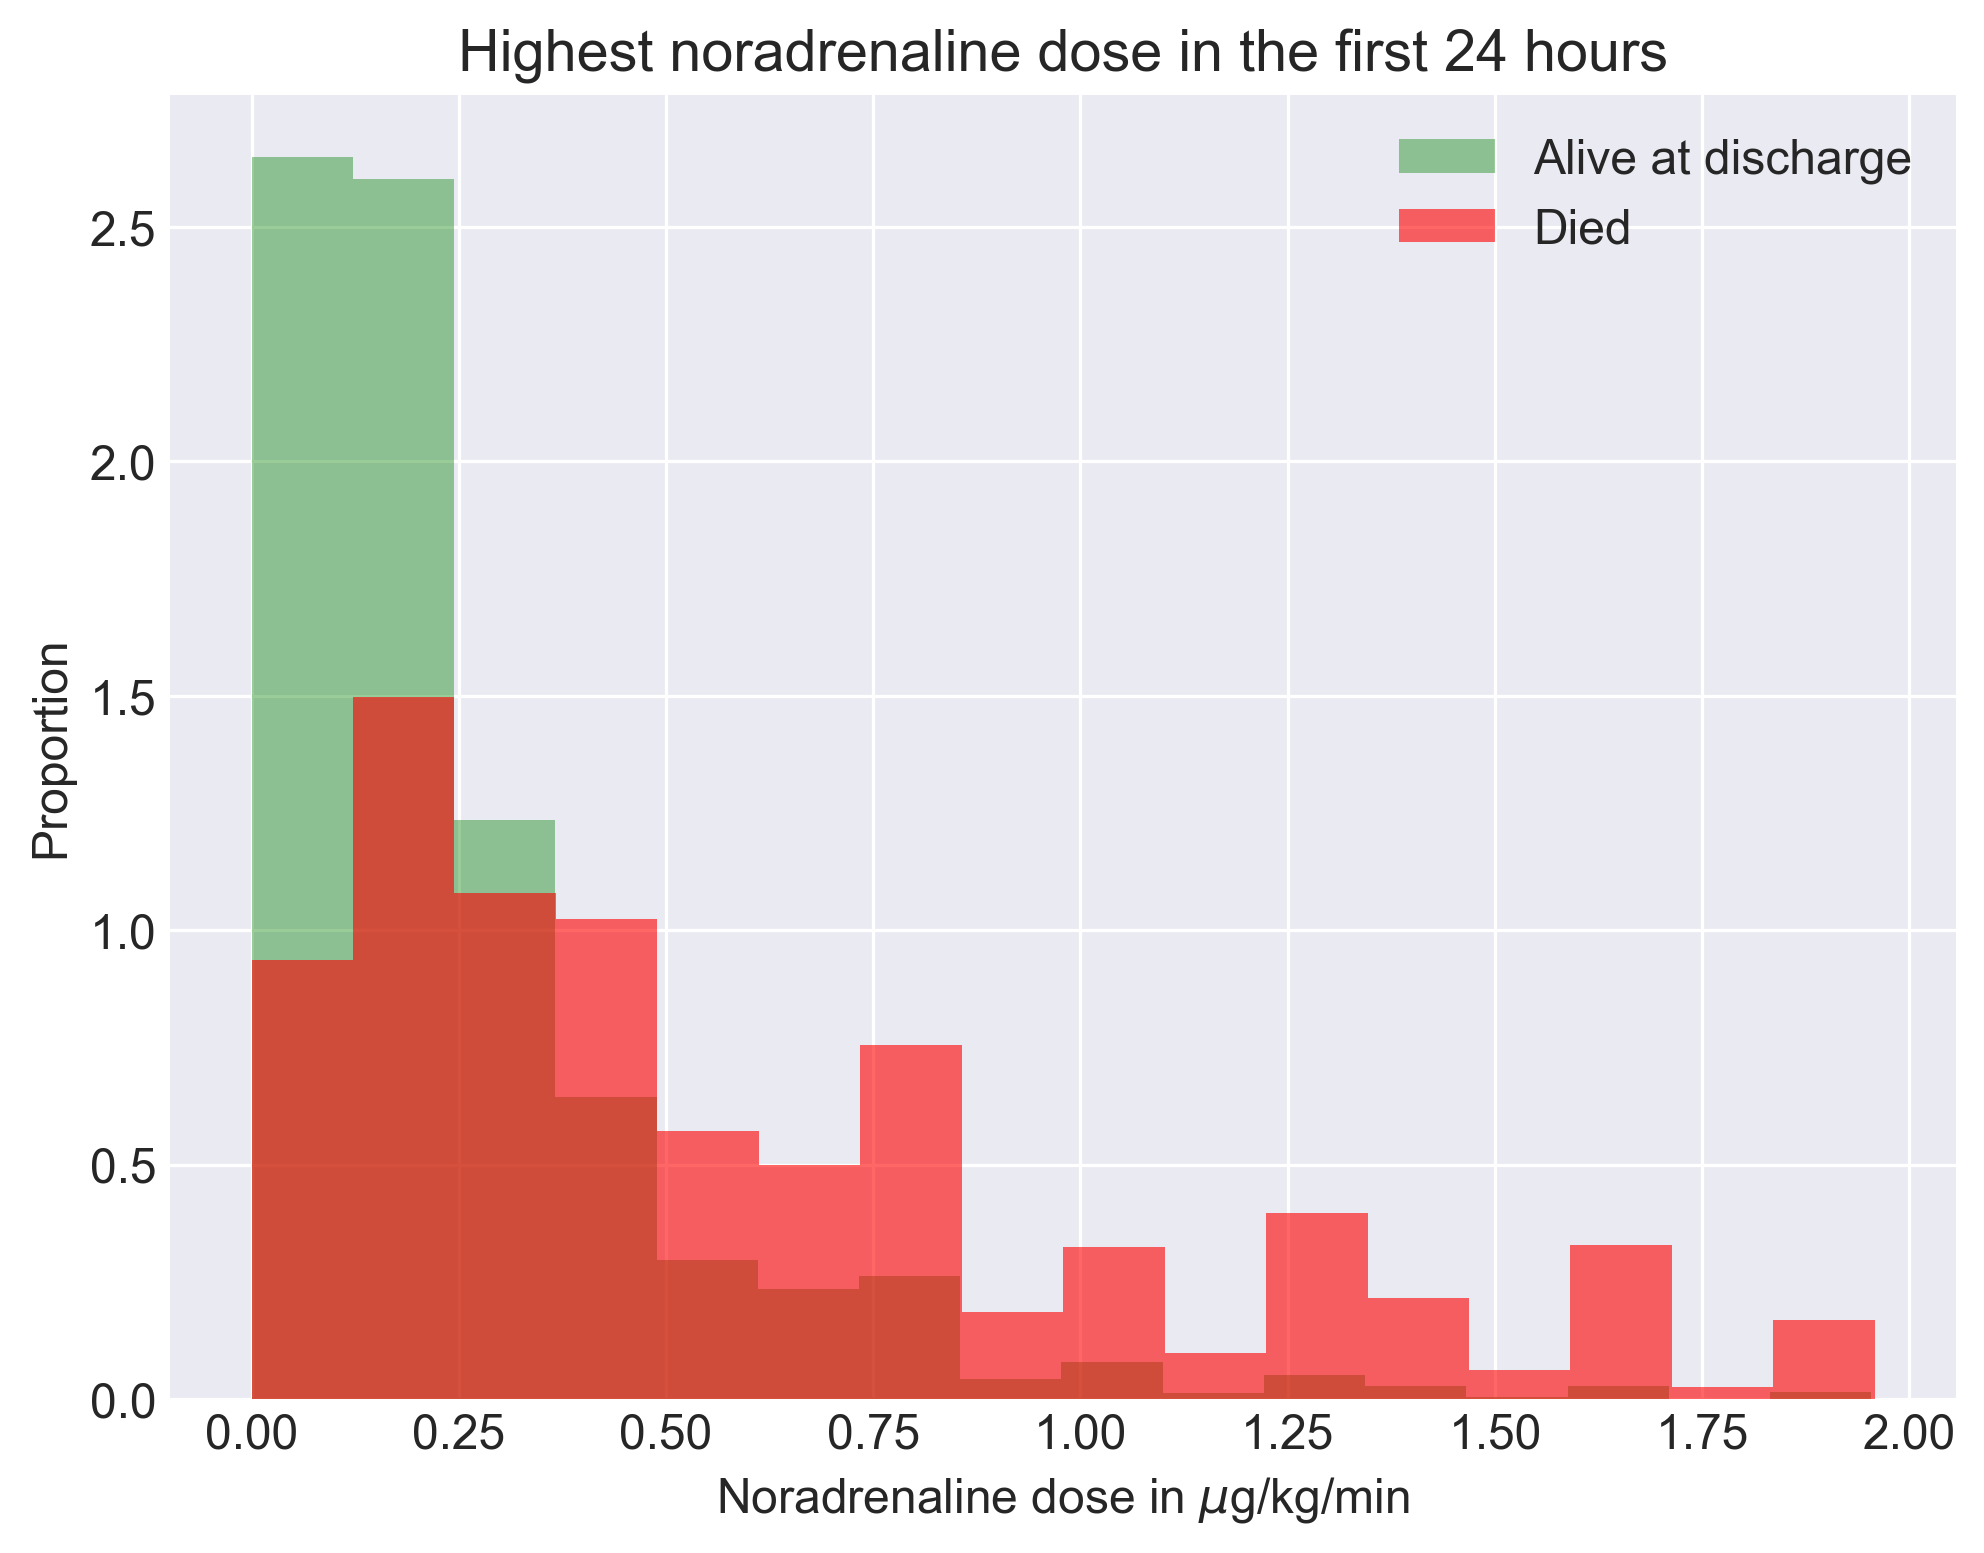

In [17]:
first24hours = 24*60*60*1000 #first 24 hours in milliseconds

#get the highest noradrenalin dose during the first 24 hours
died = df[(df['gamma'] < 2) & (df['died'] == 1)& (df['start'] < first24hours)].groupby('admissionid')['gamma'].max()
alive = df[(df['gamma'] < 2) & (df['died'] == 0)& (df['start'] < first24hours)].groupby('admissionid')['gamma'].max()

fig, ax = plt.subplots()

rects1 = ax.hist(alive, bins=16, density=True, facecolor='g', alpha=0.40, label='Alive at discharge')
rects2 = ax.hist(died, bins=16, density=True, facecolor='r', alpha=0.60, label='Died')
ax.legend()
ax.set_ylabel('Proportion')
ax.set_xlabel(r'Noradrenaline dose in $\mu $g/kg/min')
ax.set_title('Highest noradrenaline dose in the first 24 hours')

## <a id=action></a> action

In [18]:
sql = """
SELECT DISTINCT action
FROM drugitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT DISTINCT action
FROM drugitems

```

,action
0,Flush
1,Nieuwe portie
2,Herstart
3,Nieuwe toediening
4,
5,Snelheid veranderd
6,Nieuwe zak
7,Nieuwe spuit
